In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.image as mpimg
import pandas as pd
import ntpath
import random

In [2]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv("driving_log.csv", names = columns)
#pd.set_option("display.max_colwidth", -1)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsus...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,0.0,0.0,0.0,0.000081
1,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsus...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,0.0,0.0,0.0,0.000078
2,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsus...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,0.0,0.0,0.0,0.000079
3,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsus...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,0.0,0.0,0.0,0.000079
4,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsus...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,C:\Users\Dell XPS\OneDrive\Desktop\mlsus\mlsu...,0.0,0.0,0.0,0.000079


In [3]:
def path_leaf(path):
    head, tail =ntpath.split(path)
    return tail

df['center']=df['center'].apply(path_leaf)
df['left']=df['left'].apply(path_leaf)
df['right']=df['right'].apply(path_leaf)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_01_02_19_24_19_698.jpg,left_2024_01_02_19_24_19_698.jpg,right_2024_01_02_19_24_19_698.jpg,0.0,0.0,0.0,0.000081
1,center_2024_01_02_19_24_19_798.jpg,left_2024_01_02_19_24_19_798.jpg,right_2024_01_02_19_24_19_798.jpg,0.0,0.0,0.0,0.000078
2,center_2024_01_02_19_24_19_900.jpg,left_2024_01_02_19_24_19_900.jpg,right_2024_01_02_19_24_19_900.jpg,0.0,0.0,0.0,0.000079
3,center_2024_01_02_19_24_20_002.jpg,left_2024_01_02_19_24_20_002.jpg,right_2024_01_02_19_24_20_002.jpg,0.0,0.0,0.0,0.000079
4,center_2024_01_02_19_24_20_103.jpg,left_2024_01_02_19_24_20_103.jpg,right_2024_01_02_19_24_20_103.jpg,0.0,0.0,0.0,0.000079


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


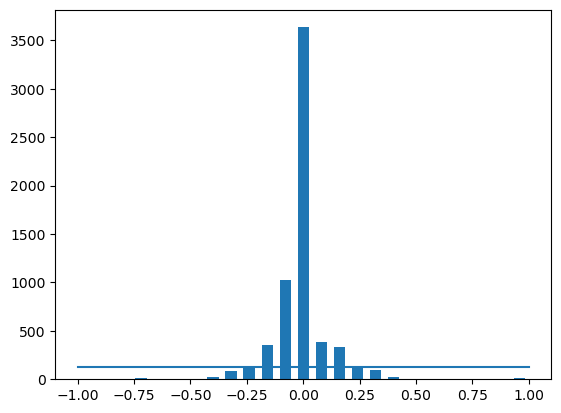

In [4]:
num_bins = 25
samples_per_bin = 125
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
print(center)
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

total data: 6259
removed 5107
remaining: 1152


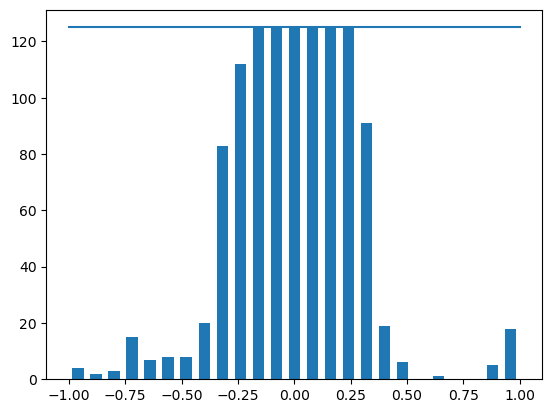

In [5]:
print("total data:", len(df))
remove_list = []
for j in range(num_bins):
    list_ =[]
    for i in range(len(df['steering'])):
        if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_= shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed', len(remove_list))
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

hist, bins = np.histogram(df['steering'], num_bins)

plt.bar(center, hist, width= 0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))


In [6]:
#print(df.iloc[1])
print(len(df))
def load_img_steering(df):
    image_path = []
    steering = []

    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center, left,right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append( 'IMG/'+center.strip())
        steering.append(float(indexed_data[3]))
    return image_path, steering
    
image_paths, steerings = load_img_steering(df)
print(len(image_paths))

1152
1152


921 231


Text(0.5, 1.0, 'Training set')

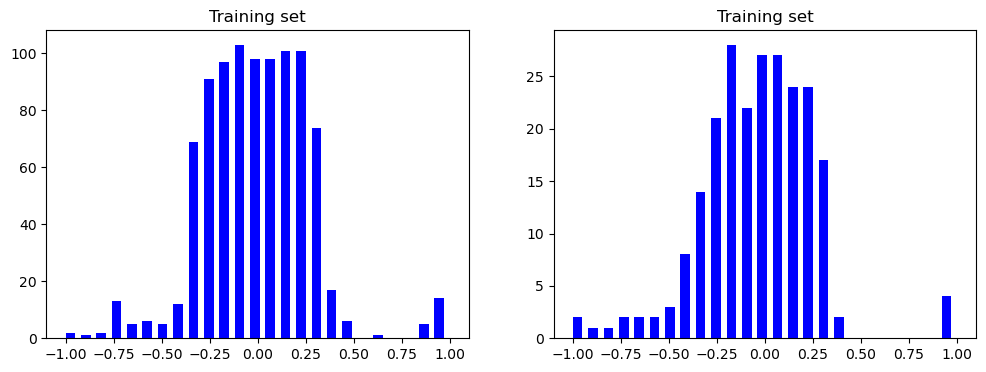

In [7]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=2)
print(len(X_train), len(X_test))

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_test, bins=num_bins, width=0.05, color='blue')
axs[1].set_title('Training set')

In [8]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0 )
    img =  cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'proprocessed image')

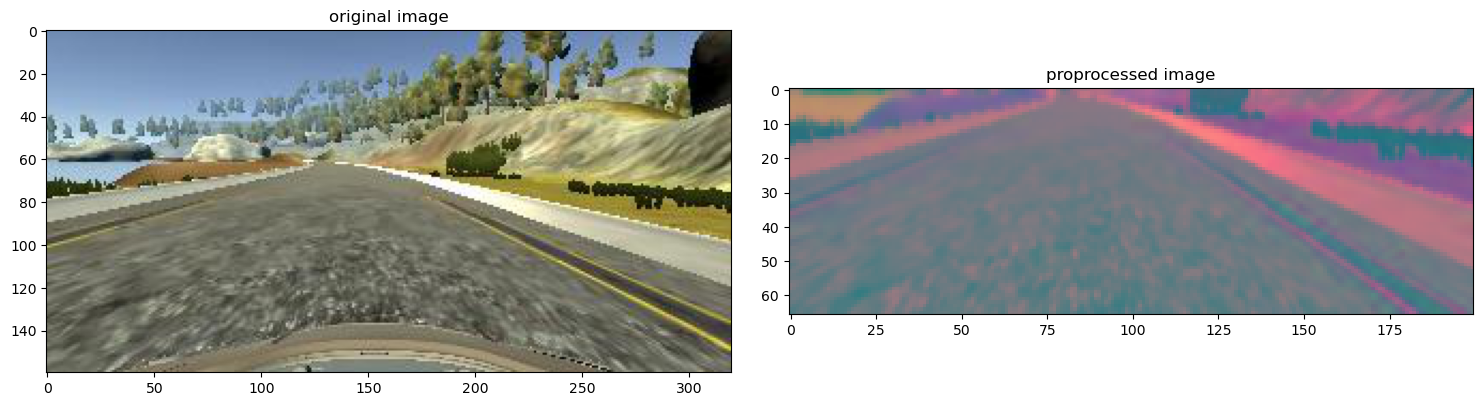

In [9]:
image = image_paths[150]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('proprocessed image')




In [10]:
X_train= np.array(list(map(img_preprocess, X_train)))
X_test = np.array(list(map(img_preprocess, X_test )))
y_train =np.array(y_train)
y_test = np.array(y_test)

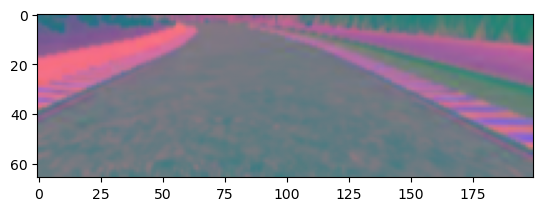

In [11]:
plt.imshow(X_train[200])

In [12]:
def nvidia_model():
 
    model = Sequential()
 
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    
    
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
    
    
    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [13]:
model = nvidia_model()
print(model.summary)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x0000021892D128D0>>


In [14]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=300, verbose=1, shuffle=1)



Epoch 1/30



4/4 [==============================] - 2s 181ms/step - loss: 0.9899 - val_loss: 0.1241
Epoch 2/30
4/4 [==============================] - 0s 117ms/step - loss: 0.1172 - val_loss: 0.0996
Epoch 3/30
4/4 [==============================] - 1s 122ms/step - loss: 0.1069 - val_loss: 0.0825
Epoch 4/30
4/4 [==============================] - 0s 115ms/step - loss: 0.0917 - val_loss: 0.0878
Epoch 5/30
4/4 [==============================] - 1s 123ms/step - loss: 0.0841 - val_loss: 0.0768
Epoch 6/30
4/4 [==============================] - 1s 123ms/step - loss: 0.0769 - val_loss: 0.0733
Epoch 7/30
4/4 [==============================] - 1s 122ms/step - loss: 0.0712 - val_loss: 0.0728
Epoch 8/30
4/4 [==============================] - 1s 137ms/step - loss: 0.0685 - val_loss: 0.0698
Epoch 9/30
4/4 [==============================] - 0s 108ms/step - loss: 0.0656 - val_loss: 0.0757
Epoch 10/30
4/4 [==============================] - 0s 119ms/step - loss: 0.0650 - val_loss: 0.0675
Epoch 11/30
4/4 [=============

Text(0.5, 0, 'Epoch')

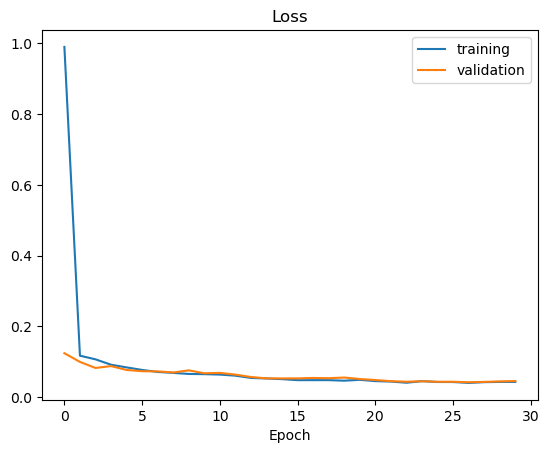

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [16]:
model.save('modle.h5')

c:\Users\Dell XPS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
